In [2]:
import torch
import torch.nn as nn
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import binned_statistic

from models import CFM
from models import Classifier
from gaussian_toy import GaussianToy
from plots import plot_naive_unfold, plot_reweighted_distribution, plot_prior_unfold

Create Gaussian toy example. Define six datasets:
1. Reco-level simulation
2. Gen-level simulation
3. Background simulation
4. Reco-level data
5. Gen-level data
6. Background data

In [3]:
data_params = { "n_dim": 1,
                "n_mc": 1000000,
                "mc_mu": 0,
                "mc_sigma": 1,
                "n_data": 1000000,
                "data_mu": 0.2,
                "data_sigma": 0.8,
                "detector_mu": 0,
                "detector_sigma": 0.5,
                "n_background": 100000,
                "background_mu": 0,
                "background_sigma": 1.2,
                "mc_rec_cut": True,
                "mc_gen_cut": True,
                "data_rec_cut": True,
                "data_gen_cut": True ,
                "efficiency": 0.1,
                "acceptance": 0.1
}

In [4]:
ToyModel = GaussianToy(data_params)

Define background subtraction classifier

In [5]:
bkg_true = torch.cat([ToyModel.data_rec[ToyModel.data_rec_mask.bool()], ToyModel.mc_background_rec])
weights_true = torch.cat([torch.ones_like(ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()]), torch.ones_like(ToyModel.mc_background_rec[:,0]) * -1])
bkg_false = ToyModel.data_rec[ToyModel.data_rec_mask.bool()]
weights_false = torch.ones_like(bkg_false[:,0])

In [6]:
background_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [7]:
background_classifier = Classifier(1, background_classifier_params)

In [8]:
background_classifier.train_classifier(bkg_true, bkg_false, weights_true, weights_false)

Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.249385952949524 after time 15.1
    Finished epoch 6 with average loss 1.2492213249206543 after time 102.3
    Finished epoch 12 with average loss 1.2490183115005493 after time 191.7
    Finished epoch 18 with average loss 1.2491294145584106 after time 282.5
    Finished epoch 24 with average loss 1.248831033706665 after time 368.0
    Finished epoch 29 with average loss 1.248957633972168 after time 439.1


In [9]:
background_weights = background_classifier.evaluate(ToyModel.data_rec[ToyModel.data_rec_mask.bool()])
background_weights = background_weights * len(ToyModel.mc_rec[ToyModel.mc_rec_mask.bool()])/ background_weights.sum()

In [10]:
# fig, axes = plt.subplots()
#
# axes.hist(ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()], bins = 60 ,histtype='step', label="signal+background", range=[-4,4])
# axes.hist(ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()], weights=background_weights, bins=60, histtype="step", label="reweighted signal", range=[-4,4])
# axes.hist(ToyModel.data_signal_rec[:,0][ToyModel.data_rec_mask[:-100000].bool()], bins=60, histtype="step", label="true signal", range=[-4,4])
# plt.show()

In [11]:
with PdfPages(f"Plots/background_suppression.pdf") as out:
    plot_reweighted_distribution(out, ToyModel.data_signal_rec[:,0][ToyModel.data_rec_mask[:-100000].bool()],
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()],
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()], reweighted_weights=background_weights,
                                 range=[-3,4], labels=[r"$\text{signal} |_r$" , "reweighted","data $(s+b)|_r$"], name="x_1")

Define efficiency classifier

In [12]:
efficiency_true = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]
efficiency_false = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool()) & ~(ToyModel.mc_gen_mask.bool())]

In [13]:
efficiency_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [14]:
efficiency_classifier = Classifier(1, efficiency_classifier_params)

In [15]:
efficiency_classifier.train_classifier(efficiency_true, efficiency_false, balanced=False)

    Training with unbalanced training set with weight 9.012155077416267
Training classifier for 270 epochs with lr 0.0001
    Finished epoch 0 with average loss 3.8171980381011963 after time 1.3
    Finished epoch 54 with average loss 3.252183437347412 after time 74.5
    Finished epoch 108 with average loss 3.252070903778076 after time 146.7
    Finished epoch 162 with average loss 3.252070426940918 after time 217.1
    Finished epoch 216 with average loss 3.2520668506622314 after time 288.9
    Finished epoch 269 with average loss 3.252094268798828 after time 358.8


In [16]:
efficiency = efficiency_classifier.evaluate(ToyModel.data_rec[ToyModel.data_rec_mask.bool()], return_weights=False)

In [17]:
# fig, axes = plt.subplots()
#
# axes.hist(ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()], bins = 60 ,histtype='step', label="signal+background", range=[-4,4])
# axes.hist(ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()], weights=background_weights*efficiency, bins=60, histtype="step", label="reweighted signal", range=[-4,4])
# axes.hist(ToyModel.data_signal_rec[:,0][(ToyModel.data_rec_mask[:-100000].bool()) & (ToyModel.data_gen_mask.bool())], bins=60, histtype="step", label="true signal", range=[-4,4])
# plt.show()

In [33]:
with PdfPages(f"Plots/acceptance_effects.pdf") as out:
    plot_reweighted_distribution(out, ToyModel.data_signal_rec[:,0][(ToyModel.data_rec_mask[:-100000].bool()) & (ToyModel.data_gen_mask.bool())],
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()],
                                 ToyModel.data_rec[:,0][ToyModel.data_rec_mask.bool()], reweighted_weights=efficiency*background_weights,
                                 fake_weights=background_weights,
                                 range=[-3,4], labels=[r"$\text{signal}|_{g,r}$" , "$\epsilon$ (data -b)","data -b"], name="x_1")

Train CFM unfolding network

In [19]:
iterative_unfolding_params = { "iterations" : 5,
                               "generator": { "hidden_layers": 4,
                                            "internal_size": 64,
                                            "lr": 1.e-4,
                                            "n_epochs" : 30,
                                            "batch_size" : 128,
                                            "batch_size_sample": 2000},
                               "classifier": {"hidden_layers": 4,
                                            "internal_size": 64,
                                            "lr": 1.e-4,
                                            "n_epochs" : 30,
                                            "batch_size" : 128,
                                            "batch_size_sample": 2000}}

Starting with the 0.iteration.
Initalize unfolder
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.7700908780097961 after time 8.1
    Finished epoch 6 with average loss 0.7049386501312256 after time 56.6
    Finished epoch 12 with average loss 0.70506352186203 after time 105.0
    Finished epoch 18 with average loss 0.7058739066123962 after time 153.6
    Finished epoch 24 with average loss 0.7040651440620422 after time 202.2
    Finished epoch 29 with average loss 0.7054154276847839 after time 242.8
unfold data


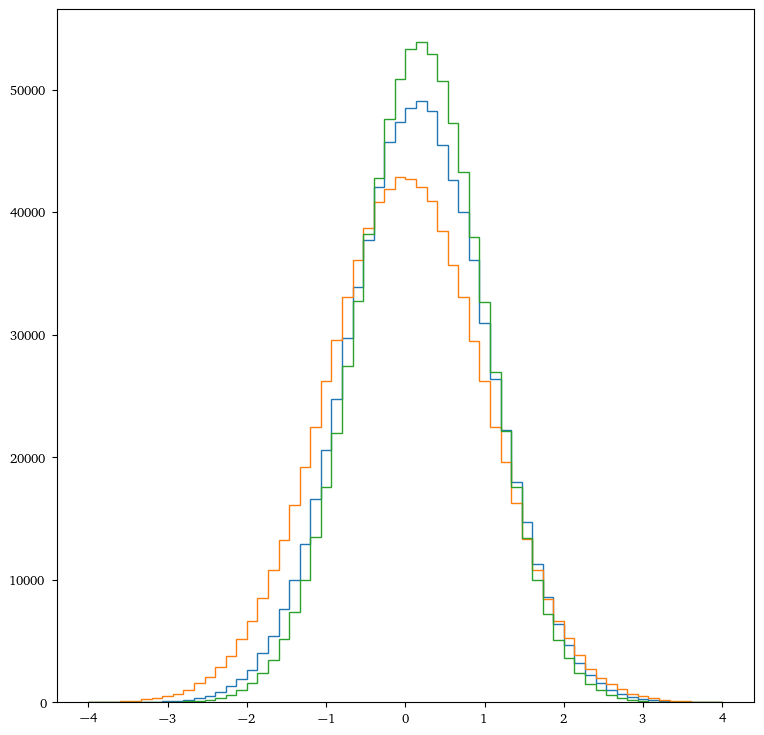

Starting with the 1.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.2374255657196045 after time 11.6
    Finished epoch 6 with average loss 1.2368428707122803 after time 81.2
    Finished epoch 12 with average loss 1.2368006706237793 after time 150.5
    Finished epoch 18 with average loss 1.236817479133606 after time 219.7
    Finished epoch 24 with average loss 1.2368004322052002 after time 289.3
    Finished epoch 29 with average loss 1.2367433309555054 after time 347.5
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.5624996423721313 after time 8.2
    Finished epoch 6 with average loss 0.5596425533294678 after time 57.8
    Finished epoch 12 with average loss 0.560599684715271 after time 107.4
    Finished epoch 18 with average loss 0.5595517158508301 after time 156.5
    Finished epoch 24 with average loss 0.5601691603660583 after time 206.6
    Finished epoch 29 with average loss 0.55883282423

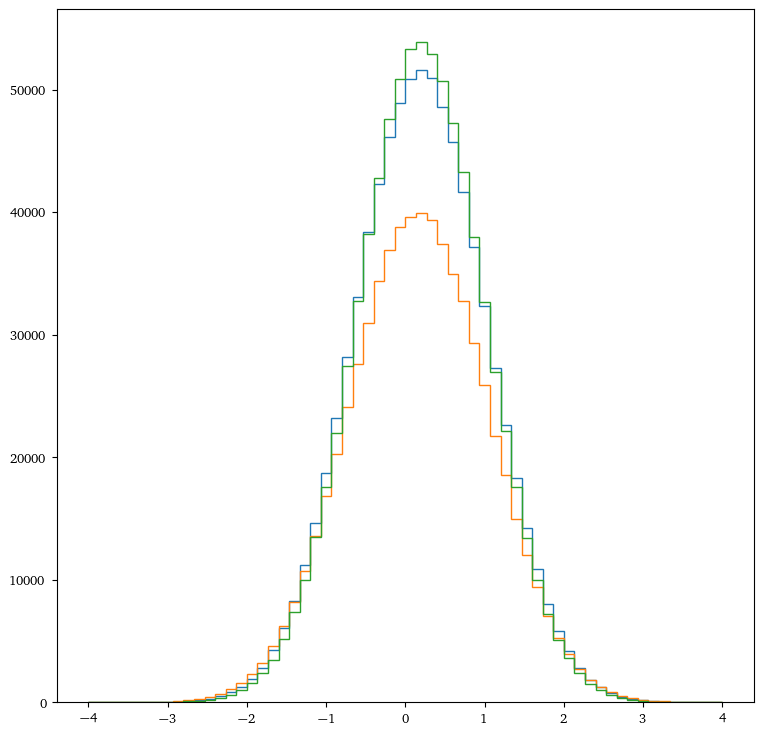

Starting with the 2.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.133778691291809 after time 12.0
    Finished epoch 6 with average loss 1.1336897611618042 after time 81.8
    Finished epoch 12 with average loss 1.1336394548416138 after time 151.8
    Finished epoch 18 with average loss 1.133663296699524 after time 222.2
    Finished epoch 24 with average loss 1.133662462234497 after time 291.6
    Finished epoch 29 with average loss 1.133669376373291 after time 349.7
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.5532224774360657 after time 8.1
    Finished epoch 6 with average loss 0.5546926856040955 after time 57.0
    Finished epoch 12 with average loss 0.5537008047103882 after time 106.0
    Finished epoch 18 with average loss 0.5518823862075806 after time 157.5
    Finished epoch 24 with average loss 0.5539968013763428 after time 206.6
    Finished epoch 29 with average loss 0.5526507496833

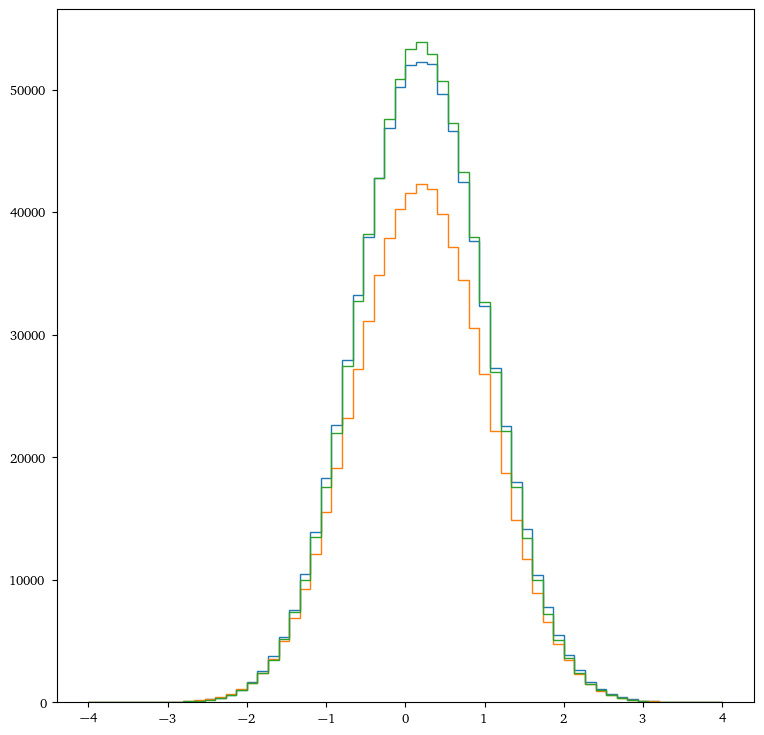

Starting with the 3.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.135981559753418 after time 11.7
    Finished epoch 6 with average loss 1.1359524726867676 after time 82.0
    Finished epoch 12 with average loss 1.1359295845031738 after time 151.5
    Finished epoch 18 with average loss 1.1359390020370483 after time 221.5
    Finished epoch 24 with average loss 1.135933756828308 after time 292.1
    Finished epoch 29 with average loss 1.1359238624572754 after time 350.3
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.5479650497436523 after time 8.2
    Finished epoch 6 with average loss 0.5492900609970093 after time 57.1
    Finished epoch 12 with average loss 0.5478615164756775 after time 107.0
    Finished epoch 18 with average loss 0.5476346611976624 after time 158.0
    Finished epoch 24 with average loss 0.5464688539505005 after time 207.9
    Finished epoch 29 with average loss 0.54733169078

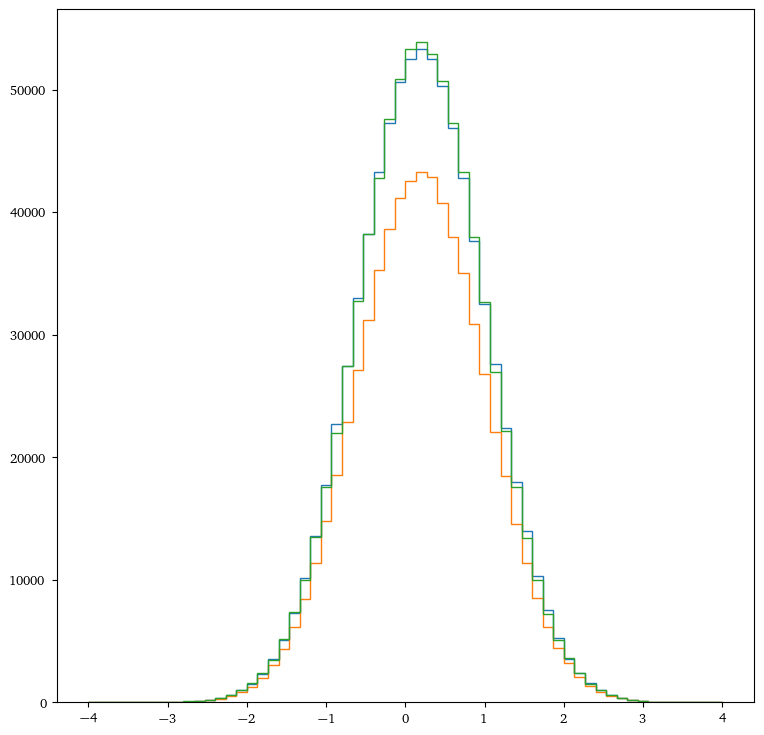

Starting with the 4.iteration.
Training classifier for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.134363055229187 after time 11.7
    Finished epoch 6 with average loss 1.1343554258346558 after time 83.0
    Finished epoch 12 with average loss 1.1343483924865723 after time 153.1
    Finished epoch 18 with average loss 1.1343423128128052 after time 224.2
    Finished epoch 24 with average loss 1.134326696395874 after time 293.6
    Finished epoch 29 with average loss 1.1343433856964111 after time 352.3
Training CFM for 30 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.5447421669960022 after time 8.2
    Finished epoch 6 with average loss 0.545254647731781 after time 57.2
    Finished epoch 12 with average loss 0.5455621480941772 after time 106.2
    Finished epoch 18 with average loss 0.5447486639022827 after time 155.7
    Finished epoch 24 with average loss 0.5431382656097412 after time 204.5
    Finished epoch 29 with average loss 0.541967332363

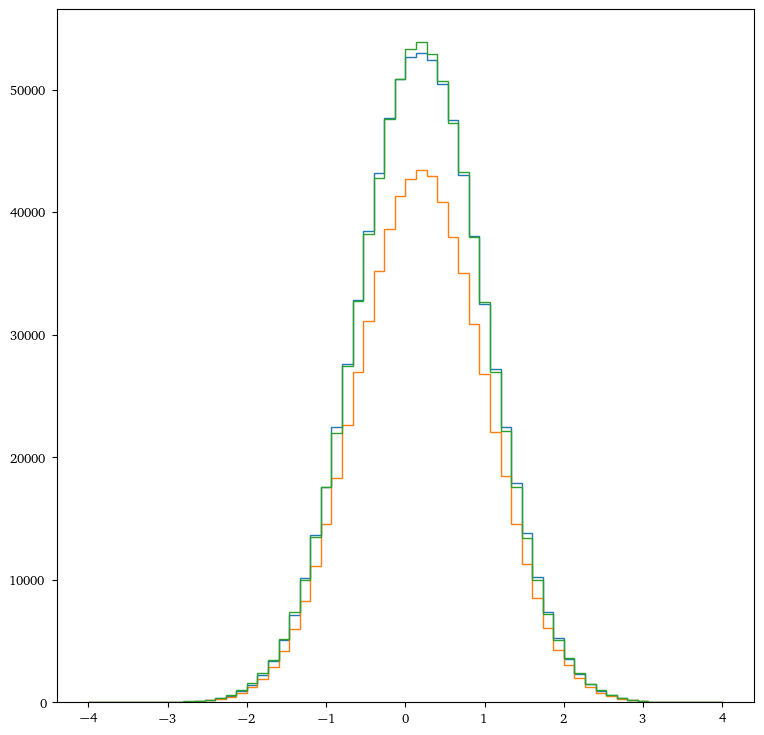

In [20]:
for i in range(iterative_unfolding_params["iterations"]):
    print(f"Starting with the {i}.iteration.")
    if i == 0:
        print("Initalize unfolder")
        unfolder = CFM(1, 1, iterative_unfolding_params["generator"])
        mc_gen = ToyModel.mc_gen[(ToyModel.mc_gen_mask.bool()) & (ToyModel.mc_rec_mask.bool())]
        mc_rec = ToyModel.mc_rec[(ToyModel.mc_gen_mask.bool()) & (ToyModel.mc_rec_mask.bool())]
        mc_weights = torch.ones_like(mc_rec[:, 0])
        data_weights = efficiency * background_weights
    if i > 0 :
        iterative_classifier = Classifier(1, iterative_unfolding_params["classifier"])
        iterative_classifier.train_classifier(data_unfold, mc_gen, data_weights, mc_weights)
        mc_weights *= iterative_classifier.evaluate(mc_gen)
    unfolder.train_unfolder(mc_gen, mc_rec, mc_weights)
    print("unfold data")
    data_unfold = unfolder.evaluate(ToyModel.data_rec[ToyModel.data_rec_mask.bool()])
    fig, axes = plt.subplots()
    axes.hist(data_unfold[:,0], weights=data_weights, bins=60, histtype="step", range=[-4,4])
    axes.hist(mc_gen[:,0], weights=mc_weights, bins=60, histtype='step', range=[-4,4])
    axes.hist(ToyModel.data_gen[:,0][(ToyModel.data_rec_mask[:-100000].bool())&(ToyModel.data_gen_mask.bool())], bins=60, range=[-4,4], histtype="step")
    plt.show()

In [21]:
# fig, axes = plt.subplots()
#
# axes.hist(plot_gen, bins =60, histtype="step",range=[-4,4])
# axes.hist(data_unfold[:, 0], bins = 60, histtype="step", range=[-4,4], label="unfolded", weights = efficiency*background_weights)
# plt.show()

In [22]:
with PdfPages(f"Plots/prior_dependence.pdf") as out:
    plot_prior_unfold(out, ToyModel.data_gen[:,0][(ToyModel.data_rec_mask[:-100000].bool()) & (ToyModel.data_gen_mask.bool())],ToyModel.mc_gen[:,0][(ToyModel.mc_gen_mask.bool()) & (ToyModel.mc_rec_mask.bool())],
                                 data_unfold[:, 0],
                      unfolded_weights=efficiency*background_weights,
                                 range=[-3,4], name="x_1")

Train acceptance classifier

In [23]:
acceptance_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [24]:
acceptance_true = ToyModel.mc_gen[(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]
acceptance_false = ToyModel.mc_gen[~(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]

In [25]:
acceptance_classifier = Classifier(1, acceptance_classifier_params)

In [26]:
acceptance_classifier.train_classifier(acceptance_true, acceptance_false, balanced=False)

    Training with unbalanced training set with weight 8.965054090863793
Training classifier for 240 epochs with lr 0.0001
    Finished epoch 0 with average loss 3.6502671241760254 after time 1.3
    Finished epoch 48 with average loss 3.247185230255127 after time 63.8
    Finished epoch 96 with average loss 3.247140407562256 after time 129.4
    Finished epoch 144 with average loss 3.2471425533294678 after time 193.0
    Finished epoch 192 with average loss 3.2471208572387695 after time 256.9
    Finished epoch 239 with average loss 3.2471225261688232 after time 318.1


In [27]:
acceptance_weights = acceptance_classifier.evaluate(data_unfold, return_weights=False)

In [28]:
data_weights =efficiency*background_weights/ acceptance_weights

In [29]:
# fig,  axes = plt.subplots()
#
# axes.hist(data_unfold[:, 0], weights = data_weights, bins=60, histtype="step", range=[-3,3])
# axes.hist(ToyModel.data_gen[(ToyModel.data_gen_mask.bool())][:, 0], histtype="step", bins=60, range=[-3,3])
# axes.hist(ToyModel.mc_gen[(ToyModel.mc_gen_mask.bool())][:, 0], histtype="step", bins=60,  range=[-3,3])
# plt.show()

In [32]:
with PdfPages(f"Plots/efficiency_effects.pdf") as out:
    plot_reweighted_distribution(out, ToyModel.data_gen[:,0][(ToyModel.data_gen_mask.bool())],
                                 data_unfold[:,0],
                                 data_unfold[:,0],
                                 reweighted_weights=efficiency*background_weights/acceptance_weights,
                                 fake_weights=efficiency*background_weights,
                                 range=[-3,4], labels=[r"$\text{gen}|_g$" , r"$\text{unfolded} / \delta$","unfolded"], name="x_1")

In [31]:
with PdfPages(f"Plots/final_unfolding.pdf") as out:
    plot_naive_unfold(out, ToyModel.data_gen[:, 0][
       (ToyModel.data_gen_mask.bool())],
                       ToyModel.data_rec[:, 0],
                      data_unfold[:, 0],
                        unfolded_weights=data_weights,
                      range=[-3, 4], name="x_1")